In [ ]:
# packages and dependencies import
import os
import pandas as pd # used for data manipulation
import seaborn as sns # Used for Exploratory Data Analysis
import numpy as np
import matplotlib # used for data visualization
import matplotlib.pyplot as plt

In [ ]:
# Data Import
data = pd.read_csv("/home/tjselevani/Desktop/Apps/vscode/python/python analysis/data/last-3-months-transactions.csv")

# Convert 'created_at' column to datetime if not already
data['created_at'] = pd.to_datetime(data['created_at'])

# Extract time in minutes since start of the day
data.loc[:, 'minutes'] = data['created_at'].dt.hour * 60 + data['created_at'].dt.minute

# Extract time in hours since start of the day
data.loc[:, 'hours'] = data['created_at'].dt.hour

# Extract the day of the week (0 = Monday, 6 = Sunday)
data.loc[:, 'day'] = data['created_at'].dt.dayofweek

#Extract date 
data.loc[:, 'date'] = data['created_at'].dt.date

# Extract the week from 'created_at'
data.loc[:, 'week'] = data['created_at'].dt.to_period('W').astype(str)

In [ ]:
def format_minutes_xticks():
    """Returns tick positions and labels for minutes of the day."""
    return range(0, 1441, 60), [f"{h}:00" for h in range(0, 25)]

def format_hours_xticks():
    """Returns tick positions and labels for hours of the day."""
    return range(0, 25, 1), [f"{h}:00" for h in range(0, 25)]

def format_days_xticks():
    """Returns tick positions and labels for days of the week."""
    days = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
    return range(len(days)), days

In [ ]:
#data.head()

In [ ]:
#data.tail()

In [ ]:
#data.shape

In [ ]:
#data.columns

In [ ]:
#data.describe()

In [ ]:
#data.isnull().sum()

In [ ]:
#Data Visualization

In [ ]:
# Filter data for the specific vehicle
def get_vehicle_data(vehicle_id):
    """Returns all, credit, and debit transaction data for a given vehicle."""
    vehicle_df = data[data['vehicle_booked'] == vehicle_id].copy()
    vehicle_dt = data[data['transaction_type'] == 'CREDIT'].copy()
    
    return {
        "all": vehicle_dt,
        "credit": vehicle_df[vehicle_df['transaction_type'] == 'CREDIT'].copy(),
        "debit": vehicle_df[vehicle_df['transaction_type'] == 'DEBIT'].copy(),
    }

# Define the vehicles
vehicles = ['SM191', 'SM192', 'SM055', 'SM024', 'SM944']

# Create a dictionary to store data for all vehicles
vehicle_data_dict = {v: get_vehicle_data(v) for v in vehicles}

# Select a specific vehicle dynamically
selected_vehicle = 'SM024'  # Change this to switch vehicles

vehicle_data = vehicle_data_dict[selected_vehicle]['credit']
vehicle_revenue = vehicle_data_dict[selected_vehicle]['debit']
data = vehicle_data_dict[selected_vehicle]['all']


In [ ]:
# Filter transactions for a specific day
specific_day = "2024-12-06"  # Example: A Wednesday
specific_date = pd.to_datetime(specific_day)

# Get the start and end of the week (Monday to Sunday)
start_of_week = specific_date - pd.DateOffset(days=specific_date.weekday())  # Get Monday of the week
end_of_week = start_of_week + pd.DateOffset(days=6)  # Get Sunday of the week

In [ ]:
# Filter transactions for a specific day
day_data = data.loc[data['created_at'].dt.date == pd.to_datetime(specific_day).date(), :].copy()

In [ ]:
day_data

In [ ]:
# Define unique colors for each vehicle, plus "Unknown" and "Failed Transactions"
vehicle_colors = {
    'SM191': 'blue',
    'SM192': 'green',
    'SM944': 'yellow',
    'SM055': 'purple',
    'SM024': 'orange',
    'Unknown': 'gray',
    'Failed': 'red'
}

In [ ]:
# Map colors to vehicle_booked, filling NaN values with a default color (e.g., gray)
day_data['color'] = day_data['vehicle_booked'].map(vehicle_colors).fillna('gray')

# Override failed transactions (status 3) to always be red
day_data.loc[day_data['payment_status'] == 3, 'color'] = 'red'

# Start plotting
plt.figure(figsize=(12, 6))

# Scatter plot with assigned colors
plt.scatter(
    day_data['minutes'], day_data['amount'],
    c=day_data['color'], alpha=0.6, label="Transactions"
)

# Plot Labels
plt.title(f"Scatter Plot of Credit Transactions Throughout the Day ({specific_day}) in minutes")
plt.xlabel("Time (Minutes in Day)")
plt.ylabel("Transaction Amount (ksh)")

# Format X-axis with proper tick labels
xticks, labels = format_minutes_xticks()
plt.xticks(xticks, labels=labels, rotation=45)

# Create a legend with colors for each vehicle
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w', label=veh, markersize=10, markerfacecolor=col) 
                   for veh, col in vehicle_colors.items()]

plt.legend(handles=legend_elements, title="Legend")

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

plt.savefig(f"../files/day_min_scattered_earnings_{specific_day}.png", dpi=300)

# Show the plot
plt.show()

In [ ]:
# Create a legend with colors for each vehicle
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w', label=veh, markersize=10, markerfacecolor=col) 
                   for veh, col in vehicle_colors.items()]
                   
# Create the scatter plot
plt.figure(figsize=(12, 6))
plt.scatter(day_data["hours"], day_data["amount"], c=day_data['color'], alpha=0.6, label="Transaction Amounts")
plt.title(f"Scatter Plot of Credit Transactions Throughout the Day ({specific_day}) in hours")
plt.xlabel("Time")
plt.ylabel("Amount")
plt.xticks(range(0, 25))
plt.grid(True)
plt.legend(handles=legend_elements, title="Legend")

plt.savefig(f"../files/day_hrs_scattered_earnings_{specific_day}.png", dpi=300)

plt.show()

In [ ]:
# Aggregate sum of amounts per vehicle per hour
hourly_sums = day_data.groupby(['vehicle_booked', 'hours'])['amount'].sum().reset_index()

# Create a pivot table for better visualization
pivot_data = hourly_sums.pivot(index='vehicle_booked', columns='hours', values='amount').fillna(0)

# Ensure all vehicles are present (even if they have no transactions)
for vehicle in vehicle_colors.keys():
    if vehicle not in pivot_data.index and vehicle not in ['Unknown', 'Failed']:
        pivot_data.loc[vehicle] = 0

# Ensure all 24 hours are present
all_hours = np.arange(24)  # 0 to 23 hours
pivot_data = pivot_data.reindex(columns=all_hours, fill_value=0)

# Calculate 'Unknown' category (transactions without a valid vehicle ID)
unknown_transactions = day_data[day_data['vehicle_booked'].isna() | ~day_data['vehicle_booked'].isin(vehicles)]
if not unknown_transactions.empty:
    unknown_sums = unknown_transactions.groupby('hours')['amount'].sum()
    pivot_data.loc['Unknown'] = 0  # Initialize with zeros
    for hour, amount in unknown_sums.items():
        pivot_data.loc['Unknown', hour] = amount

# Calculate 'Failed' category (transactions with payment_status 3)
failed_transactions = day_data[day_data['payment_status'] == 3]
if not failed_transactions.empty:
    failed_sums = failed_transactions.groupby('hours')['amount'].sum()
    pivot_data.loc['Failed'] = 0  # Initialize with zeros
    for hour, amount in failed_sums.items():
        pivot_data.loc['Failed', hour] = amount

# Plotting parameters
fig, ax = plt.subplots(figsize=(18, 8))
bar_width = 0.1  # Width of each bar
hour_spacing = 0.2  # Space between hour segments

# Initialize position for the first hour
current_position = 0
tick_positions = []
tick_labels = []

# Plot each hour as a segment with bars side by side
for hour in all_hours:
    # Store the center position of this hour segment for x-axis ticks
    hour_center = current_position + (len(vehicle_colors) * bar_width) / 2
    tick_positions.append(hour_center)
    tick_labels.append(f"{hour}:00")
    
    # Plot each vehicle's bar within this hour segment
    for i, (vehicle, color) in enumerate(vehicle_colors.items()):
        if vehicle in pivot_data.index:
            # Calculate the specific position for this bar
            bar_position = current_position + i * bar_width
            
            # Create the bar
            bar = ax.bar(
                bar_position, 
                pivot_data.loc[vehicle, hour], 
                width=bar_width, 
                color=color, 
                label=vehicle if hour == 0 else "", # Only add to legend once
                alpha=0.7
            )
            
            # Add value label if non-zero
            if pivot_data.loc[vehicle, hour] > 0:
                ax.text(
                    bar_position, 
                    pivot_data.loc[vehicle, hour] + max(pivot_data.values.max() * 0.02, 50), 
                    f"{int(pivot_data.loc[vehicle, hour])}",
                    ha='center', 
                    va='bottom', 
                    fontsize=8, 
                    fontweight='bold',
                    rotation=90
                )
    
    # Move position for next hour (including spacing)
    current_position += len(vehicle_colors) * bar_width + hour_spacing

# Set custom x-ticks at the center of each hour segment
ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels, rotation=45)

# Add vertical separators between hour segments (optional)
for hour in range(1, len(all_hours)):
    separator_position = hour * (len(vehicle_colors) * bar_width + hour_spacing) - hour_spacing/2
    ax.axvline(x=separator_position, color='gray', linestyle='--', alpha=0.3)

# Labels and formatting
ax.set_title(f"Total Transaction Amount per Hour of the Day ({specific_day})", fontsize=14)
ax.set_xlabel("Time of Day", fontsize=12)
ax.set_ylabel("Total Transaction Amount (KSH)", fontsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.3)

# Create legend with colored patches
legend = ax.legend(title="Vehicle", loc='upper right')
legend.get_frame().set_alpha(0.7)

# Set y-axis to start at 0
ax.set_ylim(bottom=0)

# Adjust layout for better spacing
plt.tight_layout()

plt.savefig(f"../files/day_hourly_grouped_earnings_{specific_day}.png", dpi=300)

# Show plot
plt.show()

In [ ]:
#vehicle_revenue

In [ ]:
# Filter transactions for the entire week
weekly_data = data.loc[
    (data['created_at'].dt.date >= start_of_week.date()) &
    (data['created_at'].dt.date <= end_of_week.date())
].copy()

In [ ]:
day_revenue = data.loc[data['created_at'].dt.date == pd.to_datetime(specific_day).date(), :].copy()

In [ ]:
# Add day of week and date columns for better grouping
weekly_data['day'] = weekly_data['created_at'].dt.dayofweek
weekly_data['date'] = weekly_data['created_at'].dt.date

# Get the unique dates in the week for proper labeling
unique_dates = sorted(weekly_data['date'].unique())
date_to_dayofweek = {date: day for date, day in zip(unique_dates, range(len(unique_dates)))}

# Create date labels with both day name and date
date_labels = []
for date in unique_dates:
    day_name = pd.to_datetime(date).strftime('%a')  # Mon, Tue, etc.
    date_str = pd.to_datetime(date).strftime('%m/%d')  # MM/DD format
    date_labels.append(f"{day_name}\n{date_str}")

# Aggregate revenue per vehicle per day
daily_revenue = weekly_data.groupby(['vehicle_booked', 'date'])['amount'].sum().reset_index()

# Create a pivot table for better visualization
pivot_data = daily_revenue.pivot(index='vehicle_booked', columns='date', values='amount').fillna(0)

# Ensure all vehicles are present (even if they have no transactions)
for vehicle in vehicle_colors.keys():
    if vehicle not in pivot_data.index and vehicle not in ['Unknown', 'Failed']:
        pivot_data.loc[vehicle] = 0

# Ensure all days are present
for date in unique_dates:
    if date not in pivot_data.columns:
        pivot_data[date] = 0

# Sort columns by date
pivot_data = pivot_data[sorted(pivot_data.columns)]

# Calculate 'Unknown' category (transactions without a valid vehicle ID)
unknown_transactions = weekly_data[weekly_data['vehicle_booked'].isna() | 
                                  ~weekly_data['vehicle_booked'].isin(vehicles)]
if not unknown_transactions.empty:
    unknown_sums = unknown_transactions.groupby('date')['amount'].sum()
    pivot_data.loc['Unknown'] = 0  # Initialize with zeros
    for date, amount in unknown_sums.items():
        if date in pivot_data.columns:
            pivot_data.loc['Unknown', date] = amount

# Calculate 'Failed' category (transactions with payment_status 3)
failed_transactions = weekly_data[weekly_data['payment_status'] == 3]
if not failed_transactions.empty:
    failed_sums = failed_transactions.groupby('date')['amount'].sum()
    pivot_data.loc['Failed'] = 0  # Initialize with zeros
    for date, amount in failed_sums.items():
        if date in pivot_data.columns:
            pivot_data.loc['Failed', date] = amount

# Plotting parameters
fig, ax = plt.subplots(figsize=(16, 8))
bar_width = 0.1  # Width of each bar
day_spacing = 0.3  # Space between day segments

# Initialize position for the first day
current_position = 0
tick_positions = []

# Plot each day as a segment with bars side by side
for i, date in enumerate(sorted(pivot_data.columns)):
    # Store the center position of this day segment for x-axis ticks
    day_center = current_position + (len(vehicle_colors) * bar_width) / 2
    tick_positions.append(day_center)
    
    # Plot each vehicle's bar within this day segment
    for j, (vehicle, color) in enumerate(vehicle_colors.items()):
        if vehicle in pivot_data.index:
            # Calculate the specific position for this bar
            bar_position = current_position + j * bar_width
            
            # Create the bar
            bar = ax.bar(
                bar_position, 
                pivot_data.loc[vehicle, date], 
                width=bar_width, 
                color=color, 
                label=vehicle if i == 0 else "", # Only add to legend once
                alpha=0.7
            )
            
            # Add value label if non-zero
            if pivot_data.loc[vehicle, date] > 0:
                ax.text(
                    bar_position, 
                    pivot_data.loc[vehicle, date] + max(pivot_data.values.max() * 0.02, 50), 
                    f"{int(pivot_data.loc[vehicle, date])}",
                    ha='center', 
                    va='bottom', 
                    fontsize=8, 
                    fontweight='bold',
                    rotation=90
                )
    
    # Move position for next day (including spacing)
    current_position += len(vehicle_colors) * bar_width + day_spacing

# Set custom x-ticks at the center of each day segment
ax.set_xticks(tick_positions)
ax.set_xticklabels(date_labels, rotation=45)

# Add vertical separators between day segments
for i in range(1, len(unique_dates)):
    separator_position = i * (len(vehicle_colors) * bar_width + day_spacing) - day_spacing/2
    ax.axvline(x=separator_position, color='gray', linestyle='--', alpha=0.3)

# Labels and formatting
week_start_str = start_of_week.strftime('%Y-%m-%d')
week_end_str = end_of_week.strftime('%Y-%m-%d')
ax.set_title(f"Weekly Revenue by Vehicle ({week_start_str} to {week_end_str})", fontsize=14)
ax.set_xlabel("Day of the Week", fontsize=12)
ax.set_ylabel("Total Revenue Amount (KSH)", fontsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.3)

# Create legend with colored patches
legend = ax.legend(title="Vehicle", loc='upper right')
legend.get_frame().set_alpha(0.7)

# Set y-axis to start at 0
ax.set_ylim(bottom=0)

# Add comma formatting to y-axis for better readability
from matplotlib.ticker import FuncFormatter
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))

# Adjust layout for better spacing
plt.tight_layout()

plt.savefig(f"../files/day_to_weekly_earnings_{week_start_str}_to_{week_end_str}.png", dpi=300)

# Show plot
plt.show()

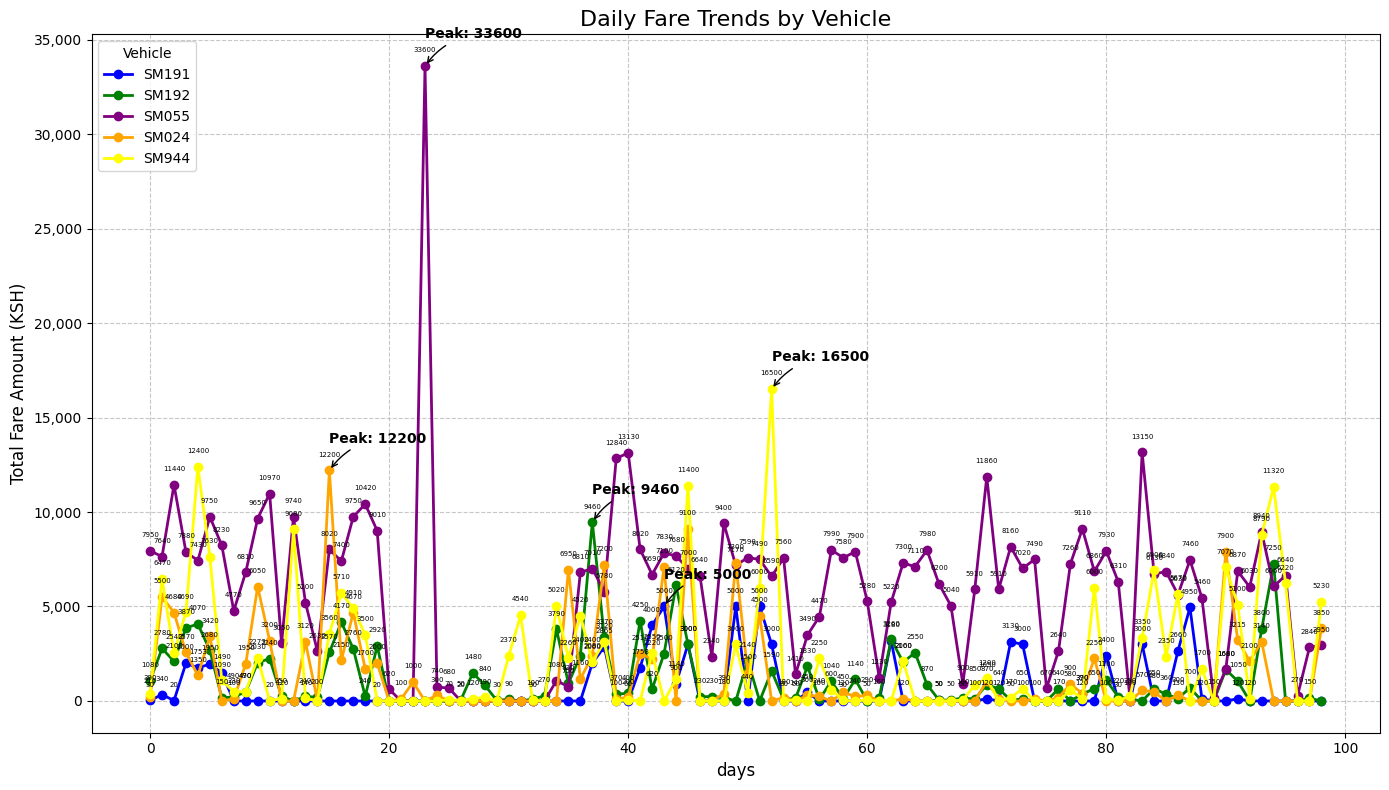

In [74]:

# Create a line graph for all vehicles' daily incomes
def plot_daily_fares_line():
 
    # Get the unique dates in the week for proper labeling
    unique_dates = sorted(data['date'].unique())
    date_to_dayofweek = {date: day for date, day in zip(unique_dates, range(len(unique_dates)))}

    # Get all unique dates in chronological order
    all_days = sorted(data['date'].unique())

    # Get all unique weeks in chronological order
    all_weeks = sorted(data['week'].unique())

    # Aggregate total fare for each vehicle by week
    daily_vehicle_fares = data.groupby(['date', 'vehicle_booked'])['amount'].sum().reset_index()
    
    # Create a pivot table for better visualization
    pivot_data = daily_vehicle_fares.pivot(index='date', columns='vehicle_booked', values='amount').fillna(0)
    
    # Ensure all vehicles are present
    for vehicle in vehicles:
        if vehicle not in pivot_data.columns:
            pivot_data[vehicle] = 0

    # # Ensure all days are present
    for date in unique_dates:
        if date not in pivot_data.columns:
            pivot_data[date] = 0


    # Reindex with all days to ensure chronological order and fill missing weeks
    pivot_data = pivot_data.reindex(all_days).fillna(0)
    
    # Create line plot
    plt.figure(figsize=(14, 8))
    
    # Plot a line for each vehicle
    for vehicle in vehicles:
        if vehicle in pivot_data.columns:
            plt.plot(
                range(len(all_days)), 
                pivot_data[vehicle], 
                marker='o', 
                linewidth=2,
                color=vehicle_colors.get(vehicle, 'gray'),
                label=f"{vehicle}"
            )
    
    # Add data point markers with values
    for vehicle in vehicles:
        if vehicle in pivot_data.columns:
            for i, (day, value) in enumerate(zip(all_days, pivot_data[vehicle])):
                if value > 0:  # Only label non-zero values
                    plt.text(
                        i, value + max(pivot_data.max().max() * 0.02, 50), 
                        f"{int(value)}",
                        ha='center', 
                        va='bottom', 
                        fontsize=5
                    )
    # Get the unique dates in the week for proper labeling
    unique_dates = sorted(weekly_data['date'].unique())
    date_to_dayofweek = {date: day for date, day in zip(unique_dates, range(len(unique_dates)))}

    # Create date labels with both day name and date
    date_labels = []
    for date in unique_dates:
        day_name = pd.to_datetime(date).strftime('%a')  # Mon, Tue, etc.
        date_str = pd.to_datetime(date).strftime('%m/%d')  # MM/DD format
        date_labels.append(f"{day_name}\n{date_str}")


    # Format day labels to be more readable
    formatted_labels = []
    for day in all_days:
        # Convert day string to datetime for better formatting
        day_name = pd.to_datetime(date).strftime('%a')  # Mon, Tue, etc.
        date_str = pd.to_datetime(date).strftime('%m/%d')  # MM/DD format
        date_labels.append(f"{day_name}\n{date_str}")
    
    # Labels and formatting
    plt.title("Daily Fare Trends by Vehicle", fontsize=16)
    plt.xlabel("days", fontsize=12)
    plt.ylabel("Total Fare Amount (KSH)", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    # plt.xticks(range(len(all_days)), formatted_labels, rotation=45, ha='right')
    
    # ax.set_xticklabels(date_labels, rotation=45)

    # Add legend
    plt.legend(title="Vehicle", loc='upper left')
    
    # Add annotations for the peaks
    for vehicle in vehicles:
        if vehicle in pivot_data.columns:
            max_value = pivot_data[vehicle].max()
            if max_value > 0:
                max_day_idx = pivot_data[vehicle].idxmax()
                max_day_position = all_days.index(max_day_idx)
                plt.annotate(
                    f"Peak: {int(max_value)}",
                    xy=(max_day_position, max_value),
                    xytext=(0, 20),
                    textcoords='offset points',
                    arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=.2'),
                    fontsize=10,
                    fontweight='bold'
                )
    
    # Format y-axis with commas
    from matplotlib.ticker import FuncFormatter
    plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
    
    # Adjust layout for better spacing
    plt.tight_layout()

    plt.savefig("../files/daily_total_earnings_trend_line.png", dpi=300)
    
    # Show plot
    plt.show()

plot_daily_fares_line()